## Load/import packages

In [20]:
import json
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from os import listdir, mkdir
from os.path import splitext
from os.path import join
from skimage import io, color

%matplotlib inline

# Check if Tensorflow uses GPU
print(tf.config.experimental.list_physical_devices("GPU"))

# Limit GPU memory usage
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

print()
print(f"Tensorflow Version: {tf.__version__}")
print(f"Numpy Version: {np.__version__}")
# print(f"OpenCV Version: {cv2.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"Keras Version: {tf.keras.__version__}")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Tensorflow Version: 2.4.0-rc0
Numpy Version: 1.19.2
Matplotlib Version: 3.3.1
Keras Version: 2.4.0


# Load datasets

The amount of images are uneven, so if I set the sequence size to an even number, in the last batch one element will have only one image in the sequence. So the image sequence lentgth needs to remain uneven

In [21]:
AW2_train_dir = r"D:\Aff-Wild2 Dataset\Aff-wild2\Sets_per_class\train"
AW2_mini_train_dir = r"D:\Aff-Wild2 Dataset\Aff-wild2\Sets_per_class\mini_train"

sequence_size = 11

# Setting label mode to categorical to one-hot encode the labels. e.g. label 0 = [1,0,0,0,0,0,0]
AW2_norm_train = image_dataset_from_directory(
    directory=AW2_train_dir,
    labels="inferred",
    label_mode="categorical",
    shuffle=False,
    color_mode="rgb",
    batch_size=sequence_size,
    image_size=(112, 112),
)

# Mini training set, only 1/9 size of the original training set
AW2_norm_minitrain = image_dataset_from_directory(
    directory=AW2_mini_train_dir,
    labels="inferred",
    label_mode="categorical",
    shuffle=False,
    color_mode="rgb",
    batch_size=sequence_size,
    image_size=(112, 112),
)

Found 922029 files belonging to 7 classes.
Found 107413 files belonging to 7 classes.


In [22]:
AW2_val_dir = r"D:\Aff-Wild2 Dataset\Aff-wild2\Sets_per_class\val"
AW2_norm_val = image_dataset_from_directory(
    directory=AW2_val_dir,
    labels="inferred",
    label_mode="categorical",
    shuffle=False,
    color_mode="rgb",
    batch_size=sequence_size,
    image_size=(112, 112),
)

Found 319323 files belonging to 7 classes.


In [23]:
type(AW2_norm_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [24]:
# Pull the first batch of 7 images
count = 0
for element in AW2_norm_minitrain:
    if count == 1:
        break
    count += 1
    values = element

In [25]:
print(values[0].shape)
print(values[1].shape)

(11, 112, 112, 3)
(11, 7)


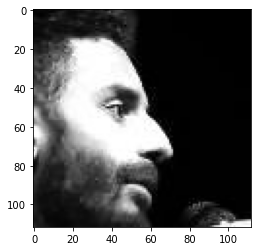

In [26]:
plt.imshow(values[0].numpy()[0].astype(int))

In [27]:
# import keras_video
# # glob_pattern='./_test/{classname}/*'

# gen = keras_video.VideoFrameGenerator(batch_size=4, nb_frames=24, glob_pattern=r'D:\Aff-Wild2 Dataset\Aff-wild2\Sets_per_class\mini_train\{classname}\*')

In [28]:
# from keras_video import utils as ku

In [29]:
# keras_video.VideoFrameGenerator

# Initiate Base CNN
For the feature extraction the pre-trained **VGG19** network will be used with the imagenet weights. Input shape is set to 112,112,3

In [30]:
base_VGG19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(112, 112, 3)
)

In [31]:
base_VGG19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0     

In [32]:
# Setup up model with base_VGG19 and all those layers frozen
# Define the sequence input size
shape = (sequence_size, 112, 112, 3)


def build_model(inp_shape):
    model = Sequential(name="CNN-RNN")
    model.add(layers.TimeDistributed(base_VGG19, input_shape=inp_shape, name="VGG19"))
    base_VGG19.trainable = False
    model.add(layers.TimeDistributed(layers.Flatten(), name="Flatten"))
    model.add(layers.LSTM(16, return_sequences=True, dropout=0.5, name="LSTM_1"))
    model.add(layers.Dense(7, activation="softmax", name="Dense_Output"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
    return model

In [33]:
cnn_rnn_LSTM = build_model(shape)
cnn_rnn_LSTM.summary()

Model: "CNN-RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VGG19 (TimeDistributed)      (None, 11, 3, 3, 512)     20024384  
_________________________________________________________________
Flatten (TimeDistributed)    (None, 11, 4608)          0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 11, 16)            296000    
_________________________________________________________________
Dense_Output (Dense)         (None, 11, 7)             119       
Total params: 20,320,503
Trainable params: 296,119
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# AW2_norm_minitrain = AW2_norm_minitrain.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

history = cnn_rnn_LSTM.fit(
    AW2_norm_train.batch(32, drop_remainder=True),
    validation_data=AW2_norm_val.batch(32, drop_remainder=True),
    epochs=10,
    verbose=1,
)

Epoch 1/10
2619/2619 [==============================] - 6703s 3s/step - loss: 0.1826 - acc: 0.9554 - val_loss: 2.1447 - val_acc: 0.1655
Epoch 2/10
 518/2619 [====>.........................] - ETA: 53:00 - loss: 1.7981 - acc: 0.2090

In [ ]:
# cnn_rnn_LSTM.evaluate(AW2_norm_train.batch(8, drop_remainder=True))

In [ ]:
history.history